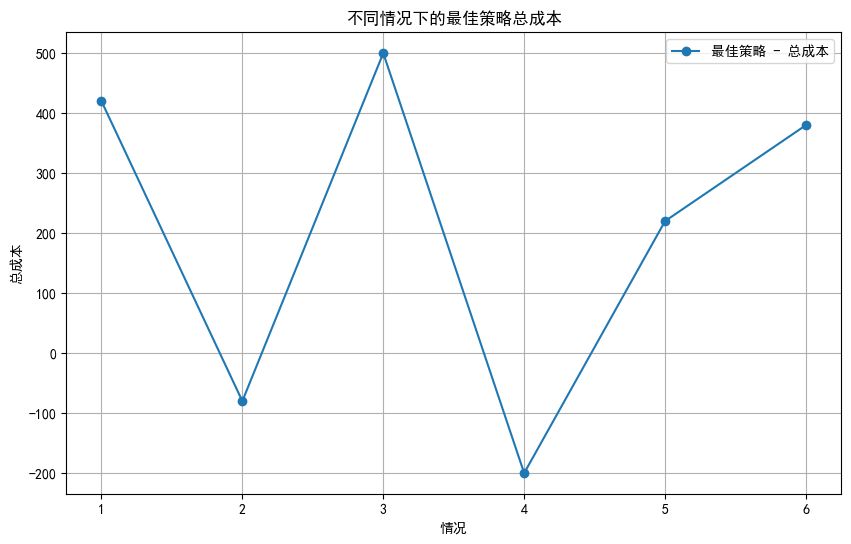

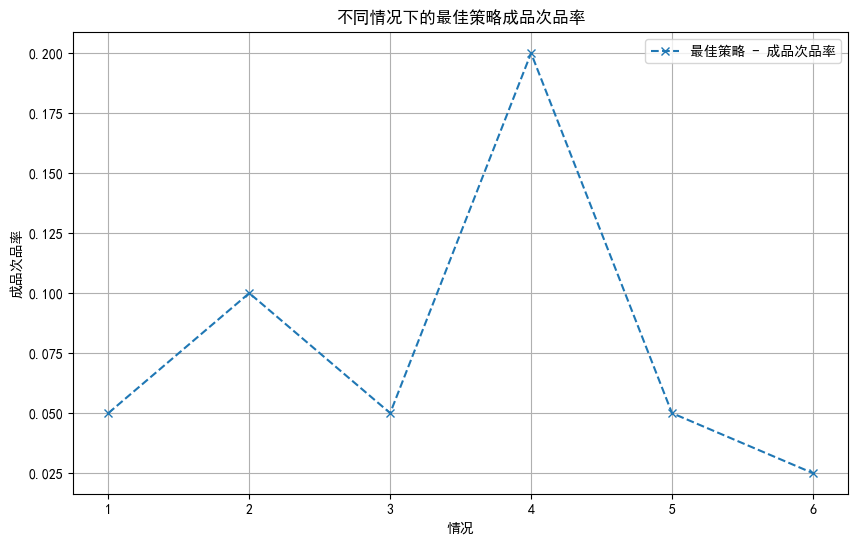

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
import csv
import openpyxl

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 定义不同情况的参数
cases = [
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 1, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.2, '成品次品率': 0.1, '零配件1检测成本': 8, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 5},
    {'零配件1次品率': 0.05, '零配件2次品率': 0.05, '成品次品率': 0.05, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 40}
]

# 计算总成本和成品次品率的函数
def calc_total_cost(case, detect_parts1=True, detect_parts2=True, detect_final=True, dismantle=True):
    n_parts1 = 100  # 零配件1的数量
    n_parts2 = 100  # 零配件2的数量
    cost_parts1 = n_parts1 * case['零配件1检测成本'] if detect_parts1 else 0  # 零配件1的检测成本
    cost_parts2 = n_parts2 * case['零配件2检测成本'] if detect_parts2 else 0  # 零配件2的检测成本

    loss_parts1 = (n_parts1 * case['零配件1次品率']) * (case['装配成本']) if not detect_parts1 else 0  # 零配件1的次品损失
    loss_parts2 = (n_parts2 * case['零配件2次品率']) * (case['装配成本']) if not detect_parts2 else 0  # 零配件2的次品损失

    n_final_products = 100  # 成品数量
    cost_final = n_final_products * case['成品检测成本'] if detect_final else 0  # 成品的检测成本
    loss_final = (n_final_products * case['成品次品率']) * case['调换损失'] if not detect_final else 0  # 成品的次品损失

    dismantle_cost = n_final_products * case['拆解费用'] if dismantle else 0  # 拆解费用
    dismantle_revenue = (n_final_products * case['成品次品率']) * case['市场售价'] if dismantle else 0  # 拆解收益

    total_cost = (cost_parts1 + cost_parts2 + loss_parts1 + loss_parts2 +
                  cost_final + loss_final + dismantle_cost - dismantle_revenue)  # 总成本

    defective_rate = case['成品次品率'] * (1 if detect_final else 0.5)  # 成品次品率

    return total_cost, defective_rate

# 适应度函数：计算策略的总成本的负值（因为我们希望最小化总成本）
def fitness_function(strategy, case):
    total_cost, _ = calc_total_cost(case, **strategy)
    return -total_cost

# 初始化种群：生成初始策略组合
def initialize_population(population_size):
    return [{
        "detect_parts1": random.choice([True, False]),
        "detect_parts2": random.choice([True, False]),
        "detect_final": random.choice([True, False]),
        "dismantle": random.choice([True, False])
    } for _ in range(population_size)]

# 选择操作：选择适应度较高的个体进行繁殖
def selection(population, fitnesses, num_parents):
    parents = []
    for _ in range(num_parents):
        max_fitness_index = fitnesses.index(max(fitnesses))
        parents.append(population[max_fitness_index])
        fitnesses[max_fitness_index] = float('-inf')
    return parents

# 变异操作：引入新的基因
def mutation(strategy, mutation_rate):
    for key in strategy:
        if random.random() < mutation_rate:
            strategy[key] = not strategy[key]
    return strategy

# 遗传算法主循环
def genetic_algorithm(case, population_size=100, num_generations=100, mutation_rate=0.01):
    population = initialize_population(population_size)
    for _ in range(num_generations):
        fitnesses = [fitness_function(strategy, case) for strategy in population]
        parents = selection(population, fitnesses, population_size // 2)
        new_population = parents[:]
        while len(new_population) < population_size:
            parent = random.choice(parents)
            child = mutation(parent, mutation_rate)
            new_population.append(child)
        population = new_population
    best_strategy = population[fitnesses.index(max(fitnesses))]
    return best_strategy

# 运行遗传算法并生成结果
best_strategies = [genetic_algorithm(case) for case in cases]

# 计算最佳策略的总成本和成品次品率
best_costs = []
best_defective_rates = []
for i, case in enumerate(cases):
    total_cost, defective_rate = calc_total_cost(case, **best_strategies[i])
    best_costs.append(total_cost)
    best_defective_rates.append(defective_rate)

# 输出结果到xlsx文件
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "B2策略"
ws.append(["策略编号", "策略描述", "总成本", "成品次品率"])
for i, strategy in enumerate(best_strategies):
    strategy_description = (
        f"检测零配件1: {'是' if strategy['detect_parts1'] else '否'}, "
        f"检测零配件2: {'是' if strategy['detect_parts2'] else '否'}, "
        f"检测成品: {'是' if strategy['detect_final'] else '否'}, "
        f"拆解不合格成品: {'是' if strategy['dismantle'] else '否'}"
    )
    ws.append([i + 1, strategy_description, best_costs[i], best_defective_rates[i]])
wb.save('B2策略.xlsx')

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cases) + 1), best_costs, marker='o', label="最佳策略 - 总成本")
plt.xlabel("情况")
plt.ylabel("总成本")
plt.title("不同情况下的最佳策略总成本")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cases) + 1), best_defective_rates, marker='x', linestyle='--', label="最佳策略 - 成品次品率")
plt.xlabel("情况")
plt.ylabel("成品次品率")
plt.title("不同情况下的最佳策略成品次品率")
plt.legend()
plt.grid(True)
plt.show()